In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imsave
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

In [0]:
%%bash
# CelebA images and attribute labels
URL=https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0
ZIP_FILE=./data/celeba.zip
mkdir -p ./data/
wget -N $URL -O $ZIP_FILE
unzip $ZIP_FILE -d ./data/
rm $ZIP_FILE

In [0]:
from model import Generator, Discriminator

In [0]:
from torch.utils import data
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from PIL import Image
import torch
import os
import random


class CelebA(data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, image_dir, attr_path, transform, mode):
        """Initialize and preprocess the CelebA dataset."""
        self.image_dir = image_dir
        self.attr_path = attr_path
        self.transform = transform
        self.mode = mode
        self.train_dataset = []
        self.test_dataset = []
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        lines = [line.rstrip() for line in open(self.attr_path, 'r')]
        all_attr_names = lines[1].split()
        
        lines = lines[2:]
        random.seed(1234)
        random.shuffle(lines)
        for i, line in enumerate(lines):
            split = line.split()
            filename = split[0]
            values = split[1:]
            
            if (i+1) < 2000:
                self.test_dataset.append(filename)
            else:
                self.train_dataset.append(filename)

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        filename = dataset[index]
        image = Image.open(os.path.join(self.image_dir, filename))
        return self.transform(image)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(image_dir, attr_path, crop_size=178, image_size=128, 
               batch_size=16, mode='train', num_workers=1):
    """Build and return a data loader."""
    transform = []
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.CenterCrop(crop_size))
    transform.append(T.Resize(image_size))
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

   
    dataset = CelebA(image_dir, attr_path, transform, mode)

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader

In [4]:
celeba_image_dir = 'data/celeba/images'
attr_path = 'data/celeba/list_attr_celeba.txt'
celeba_crop_size = 128
image_size = 128
batch_size = 32


celeba_train_loader = get_loader(celeba_image_dir, attr_path,
                                 celeba_crop_size, image_size,
                                 batch_size, 'train')

celeba_test_loader = get_loader(celeba_image_dir, attr_path,
                                celeba_crop_size, image_size,
                                batch_size, 'val')

Finished preprocessing the CelebA dataset...
Finished preprocessing the CelebA dataset...


In [0]:
import torch
from torch import autograd
from norms import sobolev_norm, lp_norm

l2_norm = 2
dual_norm = 1 / (1 - 1 / l2_norm) if l2_norm != 1 else np.inf

c_for_sobolev = 5.0
s_for_sobolev = 0

def calculate_gradient_penalty(discriminator, images, gen_images):
        epsilon = torch.FloatTensor(images.size(0), 1, 1, 1).uniform_(0., 1.).cuda()
        epsilon = epsilon.expand(images.size(0), images.size(1), images.size(2), images.size(3))
        
        x_hat = epsilon * images + ((1 - epsilon) * gen_images)
        x_hat = Variable(x_hat, requires_grad=True)

        prob_x_hat = discriminator(x_hat)
        gradients = autograd.grad(outputs=prob_x_hat, inputs=x_hat,
                                  grad_outputs=torch.ones_like(prob_x_hat).cuda(),
                                  create_graph=True, retain_graph=True)[0]
        
        dual_sobolev_gradients = sobolev_norm(gradients, s=-s_for_sobolev, c=c_for_sobolev)
        gradients_norm = lp_norm(dual_sobolev_gradients, p=dual_norm)
        
        lambda_ = lp_norm(sobolev_norm(images,  s=s_for_sobolev, c=c_for_sobolev),
                              p=l2_norm).mean()
        gamma_ = lp_norm(sobolev_norm(images, s=-s_for_sobolev, c=c_for_sobolev),
                              p=dual_norm).mean()
        
        prob_images = discriminator(images)
        
        grad_penalty = ((gradients_norm.float().cuda() / gamma_.float().cuda()  - 1) ** 2).mean() * lambda_.float().cuda()  +\
                       1e-5 * (prob_images.float().cuda()  ** 2).mean()            
        return grad_penalty, gamma_

In [0]:
def test(generator, discriminator, test_batch_generator):
    generator.eval()
    batch_num, images = test_batch_generator.__next__()
    z = torch.randn((batch_size, noise_size)).cuda()
    images, z = Variable(images.cuda()), Variable(z)
    
    gen_images = generator(z)
    fake_loss = discriminator(gen_images).mean() 
    real_loss = discriminator(images).mean()

    gradient_penalty, gamma = calculate_gradient_penalty(discriminator, images.data, gen_images.data)
        
    wasserstein_loss = (fake_loss - real_loss) / gamma

    g_loss = (gen_images).mean() / gamma
    d_loss = - wasserstein_loss + gradient_penalty
    
    return g_loss.item(), d_loss.item(), gradient_penalty.item()

  
def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('{}'.format(title))
    plt.plot(train_history['g_loss'], label='train_generator_loss', zorder=1)
    plt.plot(train_history['d_loss'], label='train_discrimintor_loss', zorder=1)
    points_g = np.array(val_history['g_loss'])
    points_d = np.array(val_history['d_loss'])
    plt.scatter(points_g[:, 0], points_g[:, 1], marker='+', s=180, c='orange', label='val_generator', zorder=2)
    plt.scatter(points_d[:, 0], points_d[:, 1], marker='+', s=180, c='red', label='val_discriminator', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.title('Gradient Penalty')
    plt.plot(train_history['grad_pen'], label='gradient_penalty', zorder=1)
    points_d = np.array(val_history['grad_pen'])
    plt.scatter(points_g[:, 0], points_g[:, 1], marker='+', s=180, c='orange', label='val_gradient_penalty', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    
    plt.show()

In [0]:
from tqdm import trange
from torch.autograd import Variable

max_iters = 100000
val_freq = 10
num_disc_iters = 5
noise_size = 128
channels = 3
img_size = 128

def generate_batches(train_loader):
    while True:
        for batch_num, x_batch_base in zip(trange(len(train_loader)), train_loader):
            yield batch_num, x_batch_base.float()
            
#Models
generator = Generator(noise_size, channels, img_size).cuda()
discriminator = Discriminator(noise_size, channels).cuda()

lr = 1e-4
beta1 = 0.
beta2 = 0.9
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Data-Generator
data = generate_batches(celeba_train_loader)
test_data = generate_batches(celeba_test_loader)

train_log = {'g_loss': [], 'd_loss' : [], 'grad_pen' : []}
val_log = {'g_loss': [], 'd_loss' : [], 'grad_pen' : []}

In [0]:
# Data-Generator
data = generate_batches(celeba_train_loader)
test_data = generate_batches(celeba_test_loader)

In [0]:
# To resore weights
generator = Generator(noise_size, channels, img_size).cuda()
generator.load_state_dict(torch.load("generator.weights"))
# generator.eval()
discriminator = Discriminator(noise_size, channels).cuda()
discriminator.load_state_dict(torch.load("discriminator.weights"))
global_iter = 0

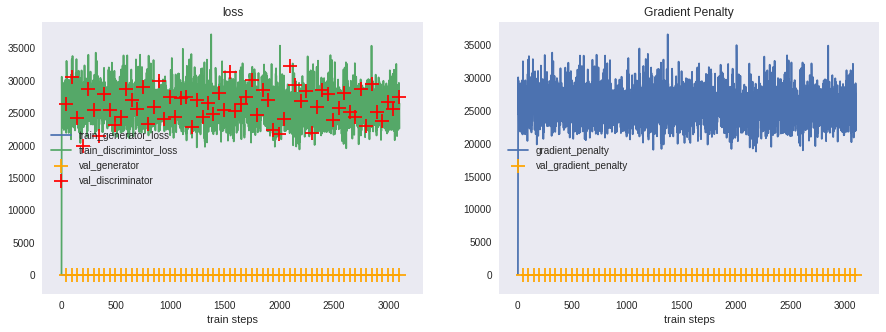

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


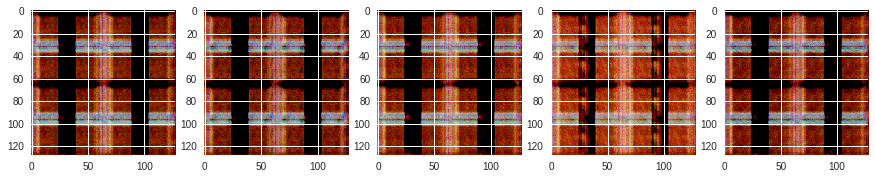


 50%|█████     | 3149/6269 [6:27:39<6:08:06,  7.08s/it]

 98%|█████████▊| 62/63 [6:21:41<06:08, 368.63s/it]

RuntimeError: ignored

In [13]:
for global_iter in range(global_iter, max_iters):
    generator.eval()
    for d_iter in range(num_disc_iters):
        batch_num, images = data.__next__()
        z = torch.randn((batch_size, noise_size)).cuda()
        images, z = Variable(images.cuda()), Variable(z)
        
        discriminator.zero_grad()
        gen_images = generator(z)
        fake_loss = discriminator(gen_images).mean()
        fake_loss.backward()
        
        real_loss = discriminator(images).mean()
        real_loss.backward(torch.FloatTensor([-1]).cuda())

        gradient_penalty, gamma = calculate_gradient_penalty(discriminator, images.data, gen_images.data)
        gradient_penalty.backward()
        
        wasserstein_loss = (fake_loss - real_loss) / gamma

        g_loss = (gen_images).mean() / gamma
        d_loss = - wasserstein_loss + gradient_penalty
        
        optimizer_D.step()
        
        
        train_log['g_loss'] += [g_loss.item()]
        train_log['d_loss'] += [d_loss.item()]
        train_log['grad_pen'] += [gradient_penalty.item()]
            #clear_output(True)
            #print ("\n[Global iter %d/%d] [Discr iter %d/%d] [D loss: %f] [G adv: %f] [Gradient Penalty: %f]" 
            #       % (global_iter, max_iters, d_iter, num_disc_iters, 
            #          d_loss.item(), g_loss.item(), gradient_penalty.item()))
    
    generator.train()
    generator.zero_grad()
            
    z = Variable(torch.randn(batch_size, noise_size)).cuda()
    gen_images = generator(z)
    g_loss = discriminator(gen_images).mean()
    g_loss.backward(torch.FloatTensor([-1]).cuda())
            
    optimizer_G.step()
   
    if global_iter % val_freq == val_freq - 1:
        g_loss_log, d_loss_log, gradient_penalty_log = test(generator, discriminator, test_data)
        val_log['g_loss'] += [(global_iter * (num_disc_iters), np.mean(g_loss_log))]
        val_log['d_loss'] += [(global_iter * (num_disc_iters), np.mean(d_loss_log))]
        val_log['grad_pen'] += [(global_iter * (num_disc_iters), np.mean(gradient_penalty_log))]
        clear_output()
        plot_history(train_log, val_log)
        
        numpy_images = gen_images.cpu().detach().numpy()
        plt.figure(figsize=(15, 3))
        
        for i in range(5):
            plt.subplot(1, 5, i + 1)
            plt.imshow(numpy_images[i].reshape((channels, img_size, img_size)).transpose((1,2,0)))
        plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


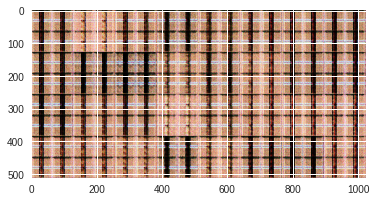

In [14]:
from torchvision.utils import make_grid
grid_imgs = make_grid(gen_images, nrow=8, padding=0, normalize=True, range=None, scale_each=False, pad_value=0)
grid_imgs = grid_imgs.cpu().detach().numpy().transpose((1,2,0))
imsave("fake_celeba.png", grid_imgs)
plt.imshow(grid_imgs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


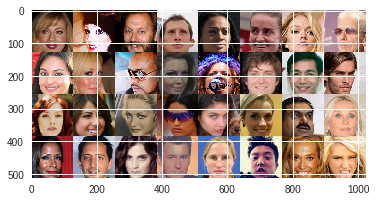

In [15]:
from torchvision.utils import make_grid
grid_imgs_real = make_grid(images, nrow=8, padding=0, normalize=True, range=None, scale_each=False, pad_value=0)
grid_imgs_real = grid_imgs_real.cpu().detach().numpy().transpose((1,2,0))
imsave("real_celeba.png", grid_imgs_real)
plt.imshow(grid_imgs_real)

In [0]:
torch.save(generator.state_dict(), "generator.weights")
torch.save(discriminator.state_dict(), "discriminator.weights")

In [0]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    
    def get_pred(x):
        if resize:
            x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear').type(dtype)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [0]:
means, stds = [], []
for i in range(500):
    generator.eval()
    z =  Variable(torch.randn((32, noise_size)).cuda())
    gen_images = generator(z)    
    mean, std = inception_score(gen_images, cuda=True, batch_size=25, resize=True, splits=10)
    means += [mean]
    stds += [std]
print(np.mean(means), np.mean(stds))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
